## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

Within this project the results from an A/B test for two website versions of an e-commerce website stored in `ab_data.csv` are analyzed and recommendations based on different tests are derived.

<a id='probability'></a>
### Part I - Probability
Calculating probabilities for conversion success of old website (`control`) and new website version (`treatment`).

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Setting the seed
random.seed(42)

`1.` Creating dataframe df form A/B testing data and checking general characteristics of dataframe

In [3]:
# Creating dataframe
df = pd.read_csv('ab_data.csv')

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Number of rows wihtin the dataset

In [5]:
# Counting number of rows
rows = df.user_id.count()
rows

294478

Number of unique users in the dataset

In [6]:
# Counting unique users
users_un = df.user_id.nunique()
users_un

290584

The proportion of users converted

In [7]:
# Mean value for column 'converted'
users_conv = df.converted.mean()
users_conv

0.11965919355605512

The number of times the `new_page` and `treatment` don't match.

In [7]:
# Calculating not matching rows
no_match1 = df.query('group == "treatment" and landing_page == "old_page"').landing_page.count()
no_match2 = df.query('group == "control" and landing_page == "new_page"').landing_page.count()

no_match_total = no_match1 + no_match2
no_match_total

3893

Do any of the rows have missing values?

In [8]:
# Checking if any null values in the df
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` Creating new dataframe exclusively with unambiguous entries which can be assigned either to `control` or to `treatment`

In [18]:
# Creating new dataframe with only matching entries for 'group' and 'landing page'
df2 = df.query('group == "treatment" and landing_page == "new_page"')
df2 = df2.append(df.query('group == "control" and landing_page == "old_page"'))

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.0+ MB


In [20]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Removing duplicated rows from df2

Number of unique users in df2

In [21]:
# Counting unique users in df2
users_un = df2.user_id.nunique()
users_un

290584

Any duplicated users?

In [13]:
# Checking if still duplicate user_ids in df2
df2.user_id.duplicated().sum()

1

In [14]:
# Identifying duplicated user_id
df2.loc[df2.user_id.duplicated() == True, ['user_id']]

,user_id
2893,773192


Identifying duplicates rows

In [15]:
# Identifying index and values for duplicated row
df2.loc[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove duplicated row

In [16]:
# Droping duplicated row by index
df2 = df2.drop(index = df2.index[df2.user_id.duplicated() == True][0])

In [17]:
# Quick check, if duplicated row has been droped
df2.user_id.duplicated().sum()

0

`4.` Calculating conversion propabilities for `control` and `treatment` groups

In [22]:
# Probability of conversion in df2
prop_conv = df2.converted.mean()
prop_conv

0.11959667567149027

Conversion probability for `control` group

In [23]:
# Probability of conversion for group 'control' in df2
prop_conv_contr = df2.query('group =="control"').converted.mean()
prop_conv_contr

0.1203863045004612

Conversion probability for `treatment` group

In [24]:
# Probability of conversion for group 'treatment' in df2
prop_conv_treat = df2.query('group == "treatment"').converted.mean()
prop_conv_treat

0.11880724790277405

Probability for reveiving the new page

In [25]:
# Probability for receiving ling page 'new_page'
prop_new_page = df2.query('landing_page == "new_page"').user_id.count()/df2.user_id.count()
prop_new_page

0.5000636646764286

Comparing conversion rates from the `control`and `treatment` group

In [26]:
# Calculating in the dataset observed difference
obs_diff = prop_conv_treat - prop_conv_contr 
obs_diff

-0.0015790565976871451

The difference in conversion rates between control and treatment group is with 0.00158 quite small and in favor of the 'control' group. However we don't know yet if this difference is significant or if it was just for chance so we are not able yet to deduce if the treatment page actually leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test
Conducting hypothesis test in order to generate better inights about conversion success of new and old version of the webpage

`1.` Defining the null hypothesis and alternate hypothesis

**H0: $p_{new} - p_{old} <= 0$**

**H1: $p_{new} - p_{old} > 0$**

`2.` Calculating test statistics via bootstrapping with 10,000 iterations and drawing conclusions based on results 

(general assumption: $p_{new}$ = $p_{old}$ = **prop_conv**)

**Conversion rate** for $p_{new}$ under the null

In [27]:
# As stated above: p_new = p_old = prop_conv
p_new = prop_conv
p_new

0.11959667567149027

**Conversion rate** for $p_{old}$ under the null

In [28]:
# As stated in the description: p_new = p_old = prop_conv
p_old = prop_conv
p_old

0.11959667567149027

Number of individuals in the treatment group: $n_{new}$

In [29]:
# Calculating n_new
n_new = df2.query('group == "treatment"').user_id.count()
n_new

145311

Number of individuals in the control group: $n_{old}$

In [30]:
# Calculating n_old
n_old = df2.query('group == "control"').user_id.count()
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**

In [31]:
# Simulating new_page_converted
new_page_converted = np.random.choice([0,1], n_new, p = (p_new, 1-p_new))
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**

In [32]:
# Simulating old_page_converted
old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
old_page_converted

array([1, 1, 1, ..., 1, 1, 0])

Calculating the difference $p_{new}$ - $p_{old}$ for the simulated values

In [33]:
# Calculating difference from simulated values
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0026740149734300056

Creating 10,000 $p_{new}$ - $p_{old}$ values via bootstrapping

In [34]:
# Bootstraping sample to simulate the sampling distribution
p_diffs = []
for _ in range(10000):
    bootsamp = df2.sample(df2.shape[0], replace = True)
    new_page_converted = np.random.choice([0,1], n_new, p=(p_new, 1-p_new))
    old_page_converted = np.random.choice([0,1], n_old, p=(p_old, 1-p_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [36]:
# Changing list to numpy array
p_diffs = np.array(p_diffs)

In [37]:
# Calculating mean value for p_diffs
p_diffs.mean()

-2.7969976708315914e-06

Plot a histogram of values in **p_diffs**

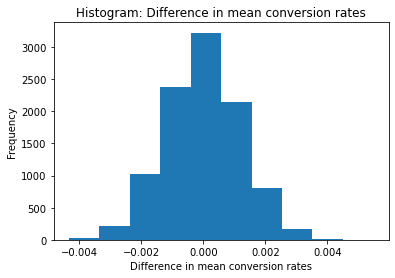

In [38]:
# plotting distribution for p_diffs
plt.hist(p_diffs)
plt.title('Histogram: Difference in mean conversion rates')
plt.xlabel('Difference in mean conversion rates')
plt.ylabel('Frequency');

Calculating proportion of **p_diffs** greater than actural difference observed in **ab_data.csv**

In [39]:
# Creating distribution under the null hypothesis
null_vals = np.random.normal(0, np.std(p_diffs), p_diffs.size)

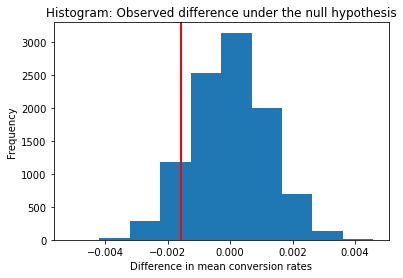

In [40]:
# Simulating null hypothesis - plotting null distribution
plt.hist(null_vals)
plt.title('Histogram: Observed difference under the null hypothesis')
plt.xlabel('Difference in mean conversion rates')
plt.ylabel('Frequency');

# plot line for observed difference in statistic
plt.axvline(x=obs_diff, color='r', linewidth=2);

In [41]:
# computing p-value
(null_vals > obs_diff).mean()

0.9049

**Interpreting results** based on obtained p-value

The p-value describes the probability of obtaining the observed statistic or one more extreme in favor of the alternate hypothesis, if the null hypothesis is true. In this case a comparatively high p-value (p_value = 0.905) means that with Type I error rate of 5% (p-value > alpa) we fail to reject the null hypothesis.

Based on these results we assume that there is not a significant difference regarding conversion rates in favor of the new page so the e-commerce company **shouldn't launch** the new website.

`3.` Testing an alternate approach of abtaining the test statistics via a z-test

In [42]:
# Importing statsmodel
import statsmodels.api as sm

In [43]:
# Calculating values requested int he decription
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

In [44]:
# Conducting z-test
sm.stats.proportions_ztest([convert_old, convert_new],[n_old,n_new], value=None, alternative='smaller')

(1.3116075339133115, 0.905173705140591)

**Interpreting results** based on obtained p-value

A z-score of 1.3109 means that that the z-score is 1.3109 standard deviations above the mean of the standard normal distribution (=0). Via the standard normal table (z table) the z-score can be associated with an area beneath the standard normal distribution. In this case it means, that to the left of the z-score there is an area of 0.9050, which corresponds with the p-value.

As the p-value calculated above is about the same as the one calculated here the interpreation from k, is also valid for the conducted z-test.

<a id='regression'></a>
### Part III - A regression approach

`1.` Comparing the conversion success rate of the website versions by using **logistic regression**.

Adding a column for the `treatment` group as well as an intercept column in order to instantiate the regression model

In [45]:
# Creating dummy variable 'ab_page'
df2[['control','ab_page']] = pd.get_dummies(df['group'])

In [46]:
# dropping unnecessary column
df2 = df2.drop(['control'], axis=1)

In [47]:
# Adding intercept columns
df2['intercept'] = 1

In [48]:
# Checking if the columns have been added to the df
df2.head(1)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1


Instantiate regression model with created columns 'intercept' and 'ab_page'

In [49]:
# Instantiating and fitting regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Showing summary for regression model

In [50]:
# Providing summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:               8.085e-06
Time:                        15:55:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

**Interpreting results** based on obtained p-value

The p-value associated with ab_page is 0.190. Obtained p-value differs from the ones calculated above as **Part II** was set up as a one tailed test while the **logistic regression model** is set up as a two tailed test ($Beta_{1} = 0$ and H1: $Beta_{1} != 0$).

`2.` Increasing predictive power to the regression model by considering additional factors to the model

Connecting information from file `ab_data.csv` and `contries.csv` within new dataframe df3

In [52]:
# Creating df from csv file
df_countries = pd.read_csv('countries.csv')

In [53]:
# Creating new dataframe df3 in order to join df2 and df_countries
df3 = df2.copy()
df3 = df3.join(df_countries.set_index('user_id'), on = 'user_id')

In [54]:
# Creating dummy variables for column 'country'
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

In [55]:
# Checking if the creation of dummy variables was successful
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [56]:
# Instantiating and fitting regression model
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'CA', 'UK']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


In [57]:
# Providing summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        16:00:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.315      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**Interpreting results** based on obtained p-values

The p-value of 0.129 for 'CA' and 0.456 for 'UK' which are comparatively high suggest that the influence of country on the conversion of users **is not** statistically signifificant.

`2.` Checking interactions between page and country to see if there are any significatn effects on the conversion success

In [58]:
# Creating new columns for interaction between page and column
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']
df3['CA_ab_page'] = df3['CA'] * df3['ab_page']

In [59]:
# Instantiating and fitting regression model
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'UK_ab_page', 'CA_ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [60]:
# Providing summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Thu, 04 Jun 2020   Pseudo R-squ.:               2.364e-05
Time:                        16:00:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.050      0.000      -2.008      -1.984
UK_ab_page     0.0149      0.017      0.862      0.389      -0.019       0.049
CA_ab_page    -0.0752      0.038     -1.997      0.046      -0.149      -0.001
==============================================================================
"""

In [61]:
np.exp(-0.0752)

0.92755795618492

**Interpreting results** based on obtained p-values and coefficients

The p-value of 0.389 for 'UK_ab_page' suggests, that the interaction between 'UK' and 'ab_page' doesn't have a statistically significant impact on the conversion of users.

However the p-value of 0.046 is comparatively low and suggests that the combination of 'CA' and 'ab_page' does have a statistically significant impact on the conversion.

Accordingly users who are from Canada and get directed to the new page are expected to convert 0.9276 times as likely as users from the US who get directed to the old page as long as all other variables stay the same.